In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import plotly.express as px
import os
# import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import pygmt
import sys
import scipy.signal
import random
import scipy.stats as st
from scipy.spatial import cKDTree
from collections import defaultdict
from geopy.distance import geodesic
from datetime import datetime

### load files

In [2]:
def interpolate_path(path, max_distance_km=5):
    interpolated_path = []
    for i in range(len(path) - 1):
        start_point = path[i]
        end_point = path[i + 1]
        distance = geodesic(start_point, end_point).km
        if distance <= max_distance_km:
            interpolated_path.append(start_point)
        else:
            num_points = int(distance // max_distance_km) + 1
            lat_step = (end_point[0] - start_point[0]) / num_points
            lon_step = (end_point[1] - start_point[1]) / num_points
            for j in range(num_points):
                interpolated_path.append((start_point[0] + j * lat_step, start_point[1] + j * lon_step))
    interpolated_path.append(path[-1])
    return interpolated_path


# # Function to calculate the haversine distance between two points
# def approximate_distance(lat1, lon1, lat2, lon2):
#     dlat = np.abs(lat2 - lat1)
#     dlon = np.abs(lon2 - lon1)
#     avg_lat = (lat1 + lat2) / 2.0
#     distance = ((dlat * 110)**2 + (dlon * 110 * np.cos(np.radians(avg_lat)))**2)**0.5
#     return distance

# # Function to calculate the minimum distance between a point and a path
# def min_distance_to_path(lat, lon, path):
#     distances = [approximate_distance(lat, lon, path_lat, path_lon) for path_lat, path_lon in path]
#     return min(distances)
points = (-90, 90, -180, 180)
lat_min= points[0]
lat_max= points[1]
lon_min= points[2]
lon_max= points[3]

# Function to check if a path contains points within the specified area
def path_in_studied_area(path, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max):
    for lat, lon in path:
        if lon_min <= lon <= lon_max and lat_min <= lat <= lat_max:
            return True
    return False


Load the .grd file (NetCDF format)

In [3]:
! gmt grdlandmask -Rswot_masked.grd -I1m -Glandmask.grd -N1/0/0/0/0
! gmt grdmath landmask.grd vgg_swot.grd MUL = landmask_swot.grd

In [4]:
grd_file = Path('.') / 'landmask_swot.grd'
data = xr.open_dataset(grd_file, engine='netcdf4')
threshold = 10 #10 km threshold
assert np.unique(data['z']).shape[0] > 1
# Load the ASCII file containing paths
ascii_file_path = 'vector_feats.xy'
paths = defaultdict(list)
current_path = None


with open(ascii_file_path, 'r') as file:
    for line in file:
        line = line.strip()
        if line.startswith('> -L'):
            parts = line.split('-D')
            if len(parts) > 1:
                description_part = parts[1].strip('"')
                current_path = description_part.split(' ')[0]
            else:
                current_path = parts[0].split('"')[1]
            paths[current_path] = []  # Initialize the path list
        elif current_path is not None and line:
            lon, lat = map(float, line.split())
            paths[current_path].append((lat, lon))

# Interpolate additional points on each path
for key in paths:
    paths[key] = interpolate_path(paths[key], max_distance_km=threshold)

# Filter paths to only include those within the specified area
filtered_paths = {key: path for key, path in paths.items() if path_in_studied_area(path)}

In [5]:
from joblib import Parallel, delayed

# Extract the latitude and longitude data
latitudes = data['lat'].values
longitudes = data['lon'].values

dy = (latitudes[2]-latitudes[1])*111.2 # spacing in km
dx = (longitudes[2]-longitudes[1])*111.2*np.cos(latitudes.mean()/180*np.pi) # spacing in km

# Create a mask for setting values to NaN within 10 km of any path
mask = np.ones(data['z'].shape, dtype=bool)

for path in list(filtered_paths.values()):
    for sub_path in path:
        lat = sub_path[0]
        lon = sub_path[1]
        # find pixels within 10 km of the path point
        distance_y = np.abs(latitudes - lat)*111.2 # spacing in km
        distance_x = np.abs(longitudes - lon)*111.2*np.cos(latitudes.mean()/180*np.pi) # spacing in km
        distance = (np.transpose(np.tile(distance_y**2, (distance_x.shape[0],1))) + np.tile(distance_x**2, (distance_y.shape[0],1)))**0.5
        mask[distance<threshold] = False

# Set the z values to NaN where the mask is False
data['z'].values[mask == False] = 0
data.to_netcdf('VGG_SEIR_masked.grd')
print((~mask).sum())

0


In [6]:
# plt_dat = data.to_dataframe().reset_index()
# plt_dat = plt_dat[(plt_dat['lat'] >= lat_min) & (plt_dat['lat'] <= lat_max) & (plt_dat['lon'] >= lon_min) & (plt_dat['lon'] <= lon_max)]
# px.scatter(plt_dat,
#     x='lon', y='lat', color='z'
#     ).show()

In [7]:
data.to_netcdf('swot_masked.grd')

In [8]:
np.unique(data['z'])

array([-2171.9656, -2154.3652, -2041.7018, ...,  1638.7983,  1741.873 ,
        1781.3127], dtype=float32)

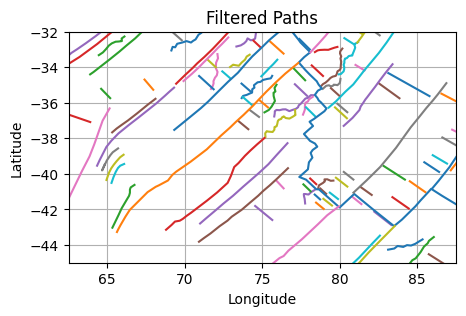

In [9]:
# Plot the filtered paths
plt.figure(figsize=(5, 3), dpi=100)
for key, path in filtered_paths.items():
    lats, lons = zip(*path)
    plt.plot(lons, lats, label=key)

# Customize the plot
plt.xlim([62.5, 87.5])
plt.ylim([-45, -32])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Filtered Paths')
# plt.legend()
plt.grid(True)
plt.show()

In [10]:
vgg_SEIR = xr.open_dataset("VGG_smooth_SEIR.grd")
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain")

fig.shift_origin(xshift="17c")
pygmt.makecpt(cmap="colors.cpt", series=[-18, 18, 1], background='o')
fig.grdimage(
    grid = xr.DataArray(vgg_SEIR.z, coords=(vgg_SEIR.lat, vgg_SEIR.lon)),
    projection="M15c",
    region = [62.5, 87.5, -45, -32],
    frame=["WSrt+tSoutheast Indian Ridge", "xa2", "ya2"],
    cmap = True,
    )
fig.plot(
    data = 'vector_features.xy',
    pen="3p,gray27,solid",
    )

fig.colorbar(position="JML+o-17c/0c+w8c/0.3c", frame=["xa5f5+lVGG", "y+lEötvös"])
# fig.savefig("SWOT_Abyssal_hills.pdf", dpi=600)
fig.show()

makecpt [ERROR]: GMT_Read_Data: File not found: colors.cpt


GMTCLibError: Module 'makecpt' failed with status code 16:
makecpt [ERROR]: GMT_Read_Data: File not found: colors.cpt